In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_data.targets # dataset.target shows the lable of the classified data

tensor([5, 0, 4,  ..., 5, 6, 8])

# What is a DataLoader ?

In PyTorch, a DataLoader is a utility class that simplifies the process of loading and iterating over datasets while training deep learning models. Here are some key features of DataLoader:

**Batching:** It can divide the dataset into smaller batches, which helps in efficient training.

**Shuffling:** It can shuffle the data to ensure that the model does not learn any unintended patterns.

**Parallel Processing:** It can load data in parallel using multiple workers, which speeds up the data loading process.

**Memory Pinning:** It can pin memory to improve the efficiency of data transfer to the GPU.

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,batch_size=100,shuffle=True,num_workers=1),
    'test': DataLoader(test_data,batch_size=100,shuffle=True,num_workers=1)
}

In [8]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ccb41a27e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ccb2597920>}

# What is nn.Model ?

The nn.Module parameter is actually quite important in PyTorch. When you define a neural network class, it should inherit from nn.Module. This inheritance provides your class with a lot of useful methods and attributes that are essential for building and training neural networks.

**Initialization and Structure:** By inheriting from nn.Module, your class gains the ability to register layers (like conv1, conv2, etc.) and parameters. This is crucial for PyTorch to keep track of the model’s parameters and their gradients.

**Forward Propagation:** The forward method is a special method in nn.Module that defines the forward pass of the network. When you call your model on an input, it automatically calls the forward method.

**Model Management:** Inheriting from nn.Module allows you to use various utility functions provided by PyTorch, such as model.eval(), model.train(), model.to(device), and more. These functions are essential for managing the model’s state and moving it between devices (CPU/GPU).

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(1,10,kernel_size=5) # 1 input channel， 10 output channel, 5x5 kernel, 10 kernels
        self.conv2 = nn.Conv2d(10,20,kernel_size=5) # 20 kernels
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x, dim=1)
    

**1.First Convolutional Layer (conv1):**
- Input: 1 channel, 28x28 (assuming MNIST dataset)
- Output: 10 channels, 24x24 (since kernel size is 5, the output size is reduced by 4)

**2.First Max Pooling Layer:**
- Output: 10 channels, 12x12 (pooling with kernel size 2 reduces each dimension by half)

**3.Second Convolutional Layer (conv2):**
- Input: 10 channels, 12x12
- Output: 20 channels, 8x8 (again, kernel size 5 reduces each dimension by 4)

**4.Second Max Pooling Layer:**
- Output: 20 channels, 4x4 (pooling with kernel size 2 reduces each dimension by half)

After these layers, the feature map has dimensions 20 channels x 4 height x 4 width. When you flatten this for the fully connected layer, you get (20 \times 4 \times 4 = 320) units.

So, the input to the first fully connected layer (fc1) is 320 units.

### Reshape:

`x = x.view(-1,320)`  reshapes the output tensor from the second max pooling layer. The original tensor has a shape of **\[batch_size, channels, height, width\]**, after it became **\[batch_size, 320\]**. This is called flattening tensor. It is necessary because fully connected layers expect 2D input **\[size, features\]**.

### Softmax:

`F.softmax(x, dim=1)` This is essential when dealing with a classification problem. We use this function to turn the output result into probabilities and make their sum-up result to 1, then we can identify the prediction as the output with the highest probability 

In [10]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # connect to gpu

device


True
2.4.1+cu124
12.4


device(type='cuda')

In [11]:
model = CNN().to(device)                                            # Initializes the CNN model and moves it to the specified device (GPU or CPU).

optimizer = optim.Adam(model.parameters(), lr=0.001)                # Initializes the Adam optimizer with the model’s parameters and a learning rate of 0.001.

loss_fn = nn.CrossEntropyLoss()                                     # Sets the loss function to CrossEntropyLoss

def train(epoch):
    model.train()                                                   # Sets the model to training mode.
    for batch_index, (data,target) in enumerate(loaders['train']):  # Iterates over the training data.
        data,target = data.to(device), target.to(device)            # Moves the data and target to the specified device.
        optimizer.zero_grad()                                       # Clears the gradients of all optimized tensors.
        output = model(data)                                        # Passes the data through the model to get the output.
        loss = loss_fn(output,target)                               # Computes the loss between the output and the target.
        loss.backward()                                             # Backpropagates the loss.
        optimizer.step()                                            # Updates the model parameters.
        if batch_index % 20 == 0:                                   # Prints the training progress every 20 batches.
            print(f'Train Epoch: {epoch} [{batch_index*len(data)}/{len(loaders["train"].dataset)} ({100.*batch_index/len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()                                                    # Sets the model to evaluation mode.

    test_loss = 0
    correct = 0                                                     # Initializes the test loss and correct predictions counters.

    with torch.no_grad():                                           # Disables gradient calculation for efficiency.
        for data, target in loaders['test']:                        # Iterates over the test data.
            data, target = data.to(device), target.to(device)       # Moves the data and target to the specified device.
            output = model(data)                                    # Passes the data through the model to get the output.
            test_loss += loss_fn(output,target).item()              # Accumulates the test loss.
            pred = output.argmax(dim=1, keepdim=True)               # Gets the predicted class.
            correct += pred.eq(target.view_as(pred)).sum().item()   # Counts the correct predictions.

    test_loss /= len(loaders['test'].dataset)                       # Averages the test loss.
    print(f'\nTest set: Average loss {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)}({100.*correct/len(loaders["test"].dataset):.0f}%\n)')

In [12]:
for epoch in range(1,11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	2.301164
Train Epoch: 1 [2000/60000 (3%)]	2.292235
Train Epoch: 1 [4000/60000 (7%)]	2.207031
Train Epoch: 1 [6000/60000 (10%)]	2.001616
Train Epoch: 1 [8000/60000 (13%)]	2.000406
Train Epoch: 1 [10000/60000 (17%)]	1.915542
Train Epoch: 1 [12000/60000 (20%)]	1.905369
Train Epoch: 1 [14000/60000 (23%)]	1.825327
Train Epoch: 1 [16000/60000 (27%)]	1.852719
Train Epoch: 1 [18000/60000 (30%)]	1.852872
Train Epoch: 1 [20000/60000 (33%)]	1.745230
Train Epoch: 1 [22000/60000 (37%)]	1.717843
Train Epoch: 1 [24000/60000 (40%)]	1.732881
Train Epoch: 1 [26000/60000 (43%)]	1.763530
Train Epoch: 1 [28000/60000 (47%)]	1.669559
Train Epoch: 1 [30000/60000 (50%)]	1.736648
Train Epoch: 1 [32000/60000 (53%)]	1.685609
Train Epoch: 1 [34000/60000 (57%)]	1.682376
Train Epoch: 1 [36000/60000 (60%)]	1.632298
Train Epoch: 1 [38000/60000 (63%)]	1.618492
Train Epoch: 1 [40000/60000 (67%)]	1.761797
Train Epoch: 1 [42000/60000 (70%)]	1.650318
Train Epoch: 1 [44000/60000 (73%)]	1.619906

Prediction: 7


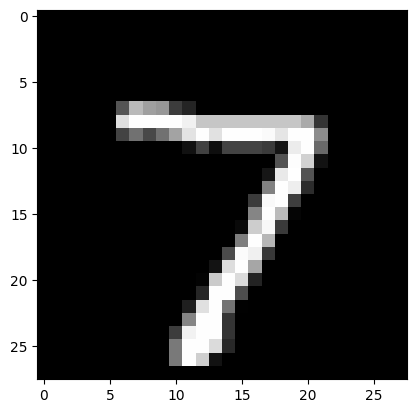

In [13]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()
